# Double Machine Learning (DML) for Observational Studies

## Workshop Overview

In this workshop, we'll explore **Double Machine Learning (DML)**, a modern causal inference method that combines machine learning with econometric theory to estimate causal effects from observational data.

### What You'll Learn:
1. **Why we need DML**: The challenges of causal inference with high-dimensional confounders
2. **Core concepts**: Orthogonalization, cross-fitting, and Neyman orthogonality
3. **Practical implementation**: Step-by-step DML using real education data
4. **Interpretation**: Understanding and presenting your results

## 1. Introduction: Why Double Machine Learning?

### The Fundamental Problem

In observational studies, we want to estimate the causal effect of a treatment (D) on an outcome (Y), but we have many confounders (X) that affect both. 

**Traditional approaches struggle when:**
- We have many confounders (high-dimensional X)
- The relationships are non-linear
- We want to use flexible ML methods but still get valid inference

**DML solves this by:**
- Using ML to flexibly control for confounders
- Maintaining valid statistical inference (confidence intervals, p-values)
- Avoiding regularization bias through orthogonalization

## 2. The College Education Dataset

We'll analyze the effect of a college preparation program on years of education completed. This is a classic observational study where treatment wasn't randomly assigned.

**Key Variables:**
- **Outcome (Y)**: Years of education completed (12-18 years)
- **Treatment (D)**: Participation in college prep program (0=No, 1=Yes)
- **Confounders (X)**: Demographics, family background, pre-test scores, geographic factors

In [7]:
# %%
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Set random seed for reproducibility
np.random.seed(42)

In [9]:
# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [10]:
# Load the dataset
df = pd.read_csv('college.csv')

# Display basic information
print("Dataset Overview")
print("=" * 50)
print(f"Number of observations: {len(df):,}")
print(f"Number of variables: {df.shape[1]}")
print(f"\nTreatment Distribution:")
print(df['treatment'].value_counts().to_frame('count'))
print(f"\nTreatment rate: {df['treatment'].mean():.1%}")

Dataset Overview
Number of observations: 4,067
Number of variables: 26

Treatment Distribution:
           count
treatment       
0           2748
1           1319

Treatment rate: 32.4%


In [11]:
# Show first few rows
print("\nFirst 5 observations:")
df.head()


First 5 observations:


,outcome,treatment,female,black,hispanic,pretest,dadmiss,dadvoc,dadsome,dadcoll,...,ownhome,perwhite,urban,cue80,stypc80,stwmfg80,dist2yr,dist4yr,dadpostgradhs,mompostgradhs
0,13,1,0,0,0,43.35,1,0,0,0,...,1,97,0,5.4,13301,8.85,5,8,0,1
1,15,1,1,0,0,49.27,1,0,0,0,...,0,100,0,7.2,13301,8.85,8,8,0,1
2,13,1,1,0,0,57.88,0,0,0,1,...,1,100,0,5.1,13301,8.85,10,1,1,1
3,13,1,0,0,0,53.50,0,0,0,0,...,1,72,0,4.0,11997,9.68,5,50,0,1
4,15,1,0,0,0,58.60,0,1,0,0,...,1,72,0,4.0,11997,9.68,5,50,1,0


In [12]:
# Define variable groups for better organization
outcome_var = 'outcome'  # Years of education
treatment_var = 'treatment'  # College prep program participation

In [13]:
# All other variables are potential confounders
confounder_vars = [col for col in df.columns if col not in [outcome_var, treatment_var]]

In [14]:
print("Variable Categories:")
print("=" * 50)
print(f"Outcome Variable: {outcome_var}")
print(f"Treatment Variable: {treatment_var}")
print(f"\nConfounding Variables ({len(confounder_vars)} total):")
print("-" * 30)

Variable Categories:
Outcome Variable: outcome
Treatment Variable: treatment

Confounding Variables (24 total):
------------------------------


In [15]:
# Categorize confounders
demographic_vars = ['female', 'black', 'hispanic']
family_vars = [col for col in confounder_vars if 'dad' in col or 'mom' in col]
economic_vars = ['fincome', 'fincmiss', 'ownhome']
academic_vars = ['pretest']
geographic_vars = ['perwhite', 'urban', 'cue80', 'stypc80', 'stwmfg80', 'dist2yr', 'dist4yr']

In [16]:
print(f"Demographics: {demographic_vars}")
print(f"Family Education: {family_vars[:6]}...")  # Show first 6
print(f"Economic: {economic_vars}")
print(f"Academic: {academic_vars}")
print(f"Geographic: {geographic_vars}")

Demographics: ['female', 'black', 'hispanic']
Family Education: ['dadmiss', 'dadvoc', 'dadsome', 'dadcoll', 'mommiss', 'momvoc']...
Economic: ['fincome', 'fincmiss', 'ownhome']
Academic: ['pretest']
Geographic: ['perwhite', 'urban', 'cue80', 'stypc80', 'stwmfg80', 'dist2yr', 'dist4yr']


### Visualizing Key Relationships

Before applying DML, let's understand the basic relationships in our data:

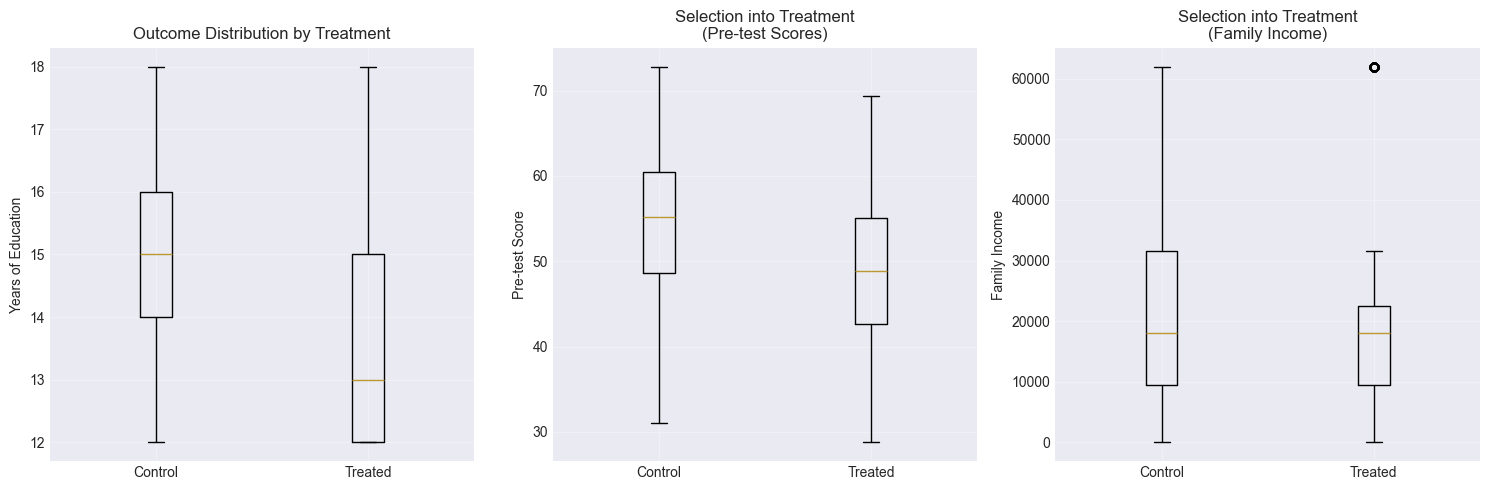

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Distribution of outcome by treatment
axes[0].boxplot([df[df['treatment']==0]['outcome'], 
                 df[df['treatment']==1]['outcome']],
                labels=['Control', 'Treated'])
axes[0].set_ylabel('Years of Education')
axes[0].set_title('Outcome Distribution by Treatment')
axes[0].grid(True, alpha=0.3)

# 2. Pre-test scores by treatment (confounder example)
axes[1].boxplot([df[df['treatment']==0]['pretest'], 
                 df[df['treatment']==1]['pretest']],
                labels=['Control', 'Treated'])
axes[1].set_ylabel('Pre-test Score')
axes[1].set_title('Selection into Treatment\n(Pre-test Scores)')
axes[1].grid(True, alpha=0.3)

# 3. Family income by treatment (another confounder)
axes[2].boxplot([df[df['treatment']==0]['fincome'], 
                 df[df['treatment']==1]['fincome']],
                labels=['Control', 'Treated'])
axes[2].set_ylabel('Family Income')
axes[2].set_title('Selection into Treatment\n(Family Income)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Calculate naive difference
naive_effect = df[df['treatment']==1]['outcome'].mean() - df[df['treatment']==0]['outcome'].mean()
print(f"\nNaive Treatment Effect (simple difference in means): {naive_effect:.3f} years")
print("Note: This is likely biased due to confounding!")


Naive Treatment Effect (simple difference in means): -1.332 years
Note: This is likely biased due to confounding!


## 4. The Double Machine Learning Framework

### The Key Insight

DML estimates the treatment effect using a two-step procedure:

1. **First Stage**: Use ML to predict:
   - The outcome Y from confounders X (getting $\hat{Y}$)
   - The treatment D from confounders X (getting $\hat{D}$)

2. **Second Stage**: Regress the residuals:
   - $(Y - \hat{Y})$ on $(D - \hat{D})$
   
This "orthogonalizes" or "partials out" the confounders, isolating the treatment effect.

### Why "Double"?
- We use ML twice (for Y and D)
- We use cross-fitting to avoid overfitting bias



## 5. Implementing DML Step-by-Step

Let's implement DML with clear explanations at each step:

### Step 1: Prepare the Data

In [20]:
# Prepare our data arrays
X = df[confounder_vars].values  # Confounders
D = df[treatment_var].values    # Treatment
Y = df[outcome_var].values      # Outcome

In [22]:
# Standardize the features (helps ML models perform better)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data prepared:")
print(f"  X shape: {X.shape} (confounders)")
print(f"  D shape: {D.shape} (treatment)")
print(f"  Y shape: {Y.shape} (outcome)")

Data prepared:
  X shape: (4067, 24) (confounders)
  D shape: (4067,) (treatment)
  Y shape: (4067,) (outcome)


### Step 2: Set Up Cross-Fitting

Cross-fitting is crucial for DML. We'll split our data into 5 folds and use out-of-sample predictions to avoid overfitting:

In [24]:
# Set up cross-fitting with 5 folds
n_folds = 5
n_samples = len(Y)

# Initialize arrays to store residuals
residuals_Y = np.zeros(n_samples)  # Will store Y - predicted_Y
residuals_D = np.zeros(n_samples)  # Will store D - predicted_D

# Create fold indices for cross-fitting
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

print(f"Cross-fitting setup:")
print(f"  Number of folds: {n_folds}")
print(f"  Samples per fold: ~{n_samples // n_folds}")
print(f"\nThis ensures we always use out-of-sample predictions!")

Cross-fitting setup:
  Number of folds: 5
  Samples per fold: ~813

This ensures we always use out-of-sample predictions!


<!-- # %% [markdown]
# ### Step 3: Cross-Fitting Loop - The Heart of DML
# 
# For each fold, we'll:
# 1. Train ML models on 4 folds
# 2. Predict on the remaining fold (out-of-sample)
# 3. Calculate residuals

# %% -->

### Step 3: Cross-Fitting Loop - The Heart of DML

For each fold, we'll:
1. Train ML models on 4 folds
2. Predict on the remaining fold (out-of-sample)
3. Calculate residuals


In [26]:
for fold_num, (train_indices, test_indices) in enumerate(kfold.split(X_scaled), 1):
    
    print(f"\nFold {fold_num}/{n_folds}:")
    
    # Split data for this fold
    X_train = X_scaled[train_indices]
    X_test = X_scaled[test_indices]
    D_train = D[train_indices]
    D_test = D[test_indices]
    Y_train = Y[train_indices]
    Y_test = Y[test_indices]
    
    print(f"  Training on {len(train_indices)} samples")
    print(f"  Testing on {len(test_indices)} samples")
    
    # --- Model 1: Predict Y from X ---
    # Using Random Forest for flexibility
    model_Y = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_leaf=10,
        random_state=42
    )
    
    # Train and predict
    model_Y.fit(X_train, Y_train)
    Y_predictions = model_Y.predict(X_test)
    
    # Calculate residuals for Y (out-of-sample)
    residuals_Y[test_indices] = Y_test - Y_predictions
    
    print(f"  ✓ Y model trained and predicted")
    
    # --- Model 2: Predict D from X ---
    # Using Random Forest Classifier since D is binary
    model_D = RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_leaf=10,
        random_state=42
    )
    
    # Train and predict (get probability of treatment)
    model_D.fit(X_train, D_train)
    D_predictions = model_D.predict_proba(X_test)[:, 1]  # Probability of D=1
    
    # Calculate residuals for D (out-of-sample)
    residuals_D[test_indices] = D_test - D_predictions
    
    print(f"  ✓ D model trained and predicted")

print("\n" + "=" * 50)
print("Cross-fitting complete! All residuals computed.")


Fold 1/5:
  Training on 3253 samples
  Testing on 814 samples
  ✓ Y model trained and predicted
  ✓ D model trained and predicted

Fold 2/5:
  Training on 3253 samples
  Testing on 814 samples
  ✓ Y model trained and predicted
  ✓ D model trained and predicted

Fold 3/5:
  Training on 3254 samples
  Testing on 813 samples
  ✓ Y model trained and predicted
  ✓ D model trained and predicted

Fold 4/5:
  Training on 3254 samples
  Testing on 813 samples
  ✓ Y model trained and predicted
  ✓ D model trained and predicted

Fold 5/5:
  Training on 3254 samples
  Testing on 813 samples
  ✓ Y model trained and predicted
  ✓ D model trained and predicted

Cross-fitting complete! All residuals computed.


### Step 4: Estimate the Treatment Effect from Residuals

Now we have:
- **residuals_Y**: The part of Y not explained by X
- **residuals_D**: The part of D not explained by X

The treatment effect is the relationship between these residuals:


**Calculate the Average Treatment Effect (ATE)**

This is the coefficient from regressing residuals_Y on residuals_D

In [27]:
# Method 1: Using the formula directly
numerator = np.sum(residuals_D * residuals_Y)
denominator = np.sum(residuals_D ** 2)
ate_dml = numerator / denominator

In [28]:
print("Treatment Effect Estimation:")
print("=" * 50)
print(f"Numerator (covariance):   {numerator:.4f}")
print(f"Denominator (variance):   {denominator:.4f}")
print(f"\nAverage Treatment Effect: {ate_dml:.4f} years")

Treatment Effect Estimation:
Numerator (covariance):   -729.6581
Denominator (variance):   715.7034

Average Treatment Effect: -1.0195 years


In [29]:
# Method 2: Verify using linear regression (should give same result)
from sklearn.linear_model import LinearRegression
final_model = LinearRegression(fit_intercept=False)
final_model.fit(residuals_D.reshape(-1, 1), residuals_Y)
ate_verify = final_model.coef_[0]

In [30]:
print(f"Verification (via regression): {ate_verify:.4f} years")
print("\n✓ Both methods give the same result!")

Verification (via regression): -1.0195 years

✓ Both methods give the same result!


### Step 5: Calculate Standard Errors for Statistical Inference

To know if our effect is statistically significant, we need standard errors:


In [35]:
# Calculate standard errors
n = len(residuals_Y)

# Residual variance from the final regression
final_residuals = residuals_Y - ate_dml * residuals_D
sigma_squared = np.sum(final_residuals ** 2) / (n - 1)

# Standard error of ATE
se_ate = np.sqrt(sigma_squared / np.sum(residuals_D ** 2))

# Calculate confidence interval
ci_lower = ate_dml - 1.96 * se_ate
ci_upper = ate_dml + 1.96 * se_ate

# Calculate t-statistic
t_statistic = ate_dml / se_ate

# Calculate p-value correctly using the t-distribution
from scipy import stats
# Degrees of freedom = n - 1 (we're estimating one parameter)
degrees_of_freedom = n - 1
# Two-tailed p-value
p_value = 2 * (1 - stats.t.cdf(abs(t_statistic), degrees_of_freedom))

print("Statistical Inference:")
print("=" * 50)
print(f"Standard Error:          {se_ate:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"t-statistic:            {t_statistic:.4f}")
print(f"p-value:                {p_value:.4f}")

Statistical Inference:
Standard Error:          0.0553
95% Confidence Interval: [-1.1279, -0.9111]
t-statistic:            -18.4266
p-value:                0.0000


In [36]:
if abs(t_statistic) > 1.96:
    print("\n✓ The effect is statistically significant at 5% level!")
else:
    print("\n✗ The effect is not statistically significant at 5% level")


✓ The effect is statistically significant at 5% level!


### Step 6: Visualize the Orthogonalized Relationship

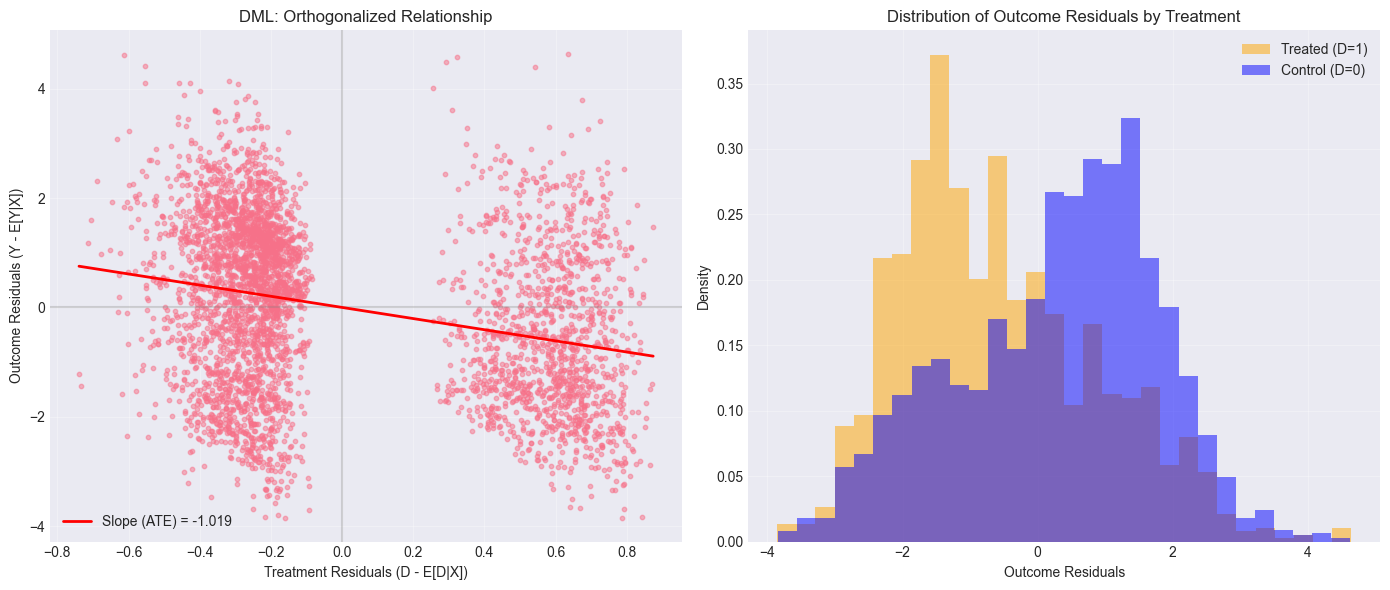

In [37]:
# Visualize the residuals and their relationship
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Scatter of residuals
axes[0].scatter(residuals_D, residuals_Y, alpha=0.5, s=10)
axes[0].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
axes[0].axvline(x=0, color='gray', linestyle='-', alpha=0.3)

# Add regression line
x_line = np.linspace(residuals_D.min(), residuals_D.max(), 100)
y_line = ate_dml * x_line
axes[0].plot(x_line, y_line, 'r-', linewidth=2, 
             label=f'Slope (ATE) = {ate_dml:.3f}')

axes[0].set_xlabel('Treatment Residuals (D - E[D|X])')
axes[0].set_ylabel('Outcome Residuals (Y - E[Y|X])')
axes[0].set_title('DML: Orthogonalized Relationship')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution of residuals
axes[1].hist(residuals_Y[residuals_D > 0], bins=30, alpha=0.5, 
             label='Treated (D=1)', density=True, color='orange')
axes[1].hist(residuals_Y[residuals_D < 0], bins=30, alpha=0.5, 
             label='Control (D=0)', density=True, color='blue')
axes[1].set_xlabel('Outcome Residuals')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of Outcome Residuals by Treatment')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Compare Different ML Methods

Let's see how robust our results are by trying different ML algorithms:

### Using LASSO (Linear with Regularization)

In [39]:
# Reset residuals for LASSO
residuals_Y_lasso = np.zeros(n_samples)
residuals_D_lasso = np.zeros(n_samples)

print("Running DML with LASSO...")
print("=" * 50)

for fold_num, (train_indices, test_indices) in enumerate(kfold.split(X_scaled), 1):
    
    # Split data
    X_train, X_test = X_scaled[train_indices], X_scaled[test_indices]
    D_train, D_test = D[train_indices], D[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]
    
    # LASSO for Y
    model_Y_lasso = LassoCV(cv=5, random_state=42)
    model_Y_lasso.fit(X_train, Y_train)
    Y_pred_lasso = model_Y_lasso.predict(X_test)
    residuals_Y_lasso[test_indices] = Y_test - Y_pred_lasso
    
    # Logistic with L1 penalty for D
    model_D_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
    model_D_lasso.fit(X_train, D_train)
    D_pred_lasso = model_D_lasso.predict_proba(X_test)[:, 1]
    residuals_D_lasso[test_indices] = D_test - D_pred_lasso
    
    print(f"  Fold {fold_num} completed")

# Calculate ATE for LASSO
ate_lasso = np.sum(residuals_D_lasso * residuals_Y_lasso) / np.sum(residuals_D_lasso ** 2)

# Standard error for LASSO
final_residuals_lasso = residuals_Y_lasso - ate_lasso * residuals_D_lasso
sigma_squared_lasso = np.sum(final_residuals_lasso ** 2) / (n - 1)
se_lasso = np.sqrt(sigma_squared_lasso / np.sum(residuals_D_lasso ** 2))

print(f"\nLASSO Results:")
print(f"  ATE: {ate_lasso:.4f} (SE: {se_lasso:.4f})")
print(f"  95% CI: [{ate_lasso - 1.96*se_lasso:.4f}, {ate_lasso + 1.96*se_lasso:.4f}]")

Running DML with LASSO...
  Fold 1 completed
  Fold 2 completed
  Fold 3 completed
  Fold 4 completed
  Fold 5 completed

LASSO Results:
  ATE: -0.9943 (SE: 0.0553)
  95% CI: [-1.1026, -0.8860]


### Using Simple Linear Models (Baseline)

In [40]:
# Reset residuals for linear models
residuals_Y_linear = np.zeros(n_samples)
residuals_D_linear = np.zeros(n_samples)

print("Running DML with Linear Models...")
print("=" * 50)

for fold_num, (train_indices, test_indices) in enumerate(kfold.split(X_scaled), 1):
    
    # Split data
    X_train, X_test = X_scaled[train_indices], X_scaled[test_indices]
    D_train, D_test = D[train_indices], D[test_indices]
    Y_train, Y_test = Y[train_indices], Y[test_indices]
    
    # Linear regression for Y
    model_Y_linear = LinearRegression()
    model_Y_linear.fit(X_train, Y_train)
    Y_pred_linear = model_Y_linear.predict(X_test)
    residuals_Y_linear[test_indices] = Y_test - Y_pred_linear
    
    # Logistic regression for D
    model_D_linear = LogisticRegression(random_state=42)
    model_D_linear.fit(X_train, D_train)
    D_pred_linear = model_D_linear.predict_proba(X_test)[:, 1]
    residuals_D_linear[test_indices] = D_test - D_pred_linear
    
    print(f"  Fold {fold_num} completed")

# Calculate ATE for linear models
ate_linear = np.sum(residuals_D_linear * residuals_Y_linear) / np.sum(residuals_D_linear ** 2)

# Standard error for linear
final_residuals_linear = residuals_Y_linear - ate_linear * residuals_D_linear
sigma_squared_linear = np.sum(final_residuals_linear ** 2) / (n - 1)
se_linear = np.sqrt(sigma_squared_linear / np.sum(residuals_D_linear ** 2))

print(f"\nLinear Model Results:")
print(f"  ATE: {ate_linear:.4f} (SE: {se_linear:.4f})")
print(f"  95% CI: [{ate_linear - 1.96*se_linear:.4f}, {ate_linear + 1.96*se_linear:.4f}]")

Running DML with Linear Models...
  Fold 1 completed
  Fold 2 completed
  Fold 3 completed
  Fold 4 completed
  Fold 5 completed

Linear Model Results:
  ATE: -0.9956 (SE: 0.0549)
  95% CI: [-1.1031, -0.8880]


## 7. Compare All Results


COMPARISON OF ALL METHODS
             Method  Treatment Effect  Standard Error  CI Lower  CI Upper
 Naive (No Control)           -1.3320             NaN       NaN       NaN
DML (Random Forest)           -1.0195          0.0553   -1.1279   -0.9111
        DML (LASSO)           -0.9943          0.0553   -1.1026   -0.8860
       DML (Linear)           -0.9956          0.0549   -1.1031   -0.8880


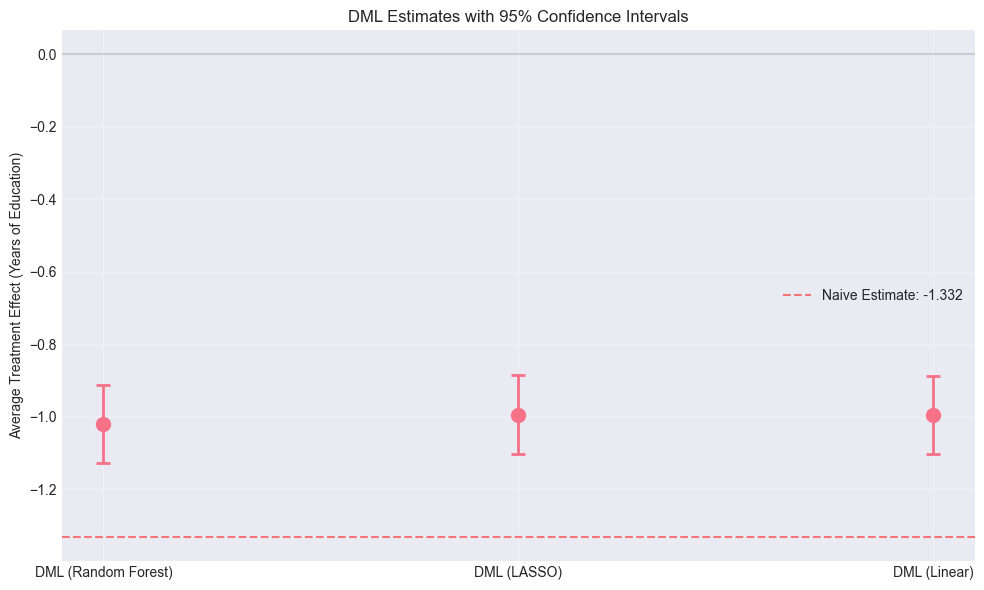

In [41]:
results_comparison = pd.DataFrame({
    'Method': ['Naive (No Control)', 'DML (Random Forest)', 'DML (LASSO)', 'DML (Linear)'],
    'Treatment Effect': [naive_effect, ate_dml, ate_lasso, ate_linear],
    'Standard Error': [np.nan, se_ate, se_lasso, se_linear],
    'CI Lower': [np.nan, ci_lower, ate_lasso - 1.96*se_lasso, ate_linear - 1.96*se_linear],
    'CI Upper': [np.nan, ci_upper, ate_lasso + 1.96*se_lasso, ate_linear + 1.96*se_linear]
})

print("\nCOMPARISON OF ALL METHODS")
print("=" * 70)
print(results_comparison.round(4).to_string(index=False))
print("=" * 70)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

methods = results_comparison['Method'].values[1:]  # Exclude naive
effects = results_comparison['Treatment Effect'].values[1:]
errors = results_comparison['Standard Error'].values[1:]

x_pos = np.arange(len(methods))
ax.errorbar(x_pos, effects, yerr=1.96*errors, fmt='o', capsize=5, capthick=2,
            markersize=10, linewidth=2)

# Add naive estimate as reference line
ax.axhline(y=naive_effect, color='red', linestyle='--', alpha=0.5, 
           label=f'Naive Estimate: {naive_effect:.3f}')
ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

ax.set_xticks(x_pos)
ax.set_xticklabels(methods, rotation=0)
ax.set_ylabel('Average Treatment Effect (Years of Education)')
ax.set_title('DML Estimates with 95% Confidence Intervals')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Interpretation of Results

In [42]:
print("=" * 70)
print("INTERPRETATION OF RESULTS")
print("=" * 70)

# Use Random Forest results as primary (most flexible)
primary_ate = ate_dml
primary_se = se_ate
primary_ci_lower = ci_lower
primary_ci_upper = ci_upper

print("\n1. MAIN FINDING:")
print(f"   The college prep program changes education by {primary_ate:.3f} years")
print(f"   95% Confidence Interval: [{primary_ci_lower:.3f}, {primary_ci_upper:.3f}]")

print("\n2. BIAS CORRECTION:")
bias = naive_effect - primary_ate
print(f"   Naive estimate:     {naive_effect:.3f} years")
print(f"   DML estimate:       {primary_ate:.3f} years")
print(f"   Selection bias:     {bias:.3f} years")
if abs(bias) > 0.1:
    print("   → Substantial confounding was present in the naive estimate!")

print("\n3. STATISTICAL SIGNIFICANCE:")
t_stat = primary_ate / primary_se
if abs(t_stat) > 1.96:
    print(f"   ✓ The effect IS statistically significant (t={t_stat:.2f}, p<0.05)")
else:
    print(f"   ✗ The effect is NOT statistically significant (t={t_stat:.2f}, p>0.05)")

print("\n4. PRACTICAL SIGNIFICANCE:")
effect_size = (primary_ate / df['outcome'].std()) * 100
print(f"   Effect size: {effect_size:.1f}% of one standard deviation")
if abs(primary_ate) > 0.5:
    print(f"   → This represents a meaningful change in educational attainment")
else:
    print(f"   → This is a relatively small effect in practical terms")

print("\n5. ROBUSTNESS:")
all_effects = [ate_dml, ate_lasso, ate_linear]
if max(all_effects) - min(all_effects) < 0.5:
    print("   ✓ Results are consistent across different ML methods")
else:
    print("   ⚠ Results vary across methods - interpret with caution")

print("=" * 70)


INTERPRETATION OF RESULTS

1. MAIN FINDING:
   The college prep program changes education by -1.019 years
   95% Confidence Interval: [-1.128, -0.911]

2. BIAS CORRECTION:
   Naive estimate:     -1.332 years
   DML estimate:       -1.019 years
   Selection bias:     -0.313 years
   → Substantial confounding was present in the naive estimate!

3. STATISTICAL SIGNIFICANCE:
   ✓ The effect IS statistically significant (t=-18.43, p<0.05)

4. PRACTICAL SIGNIFICANCE:
   Effect size: -60.4% of one standard deviation
   → This represents a meaningful change in educational attainment

5. ROBUSTNESS:
   ✓ Results are consistent across different ML methods


## 9. Check Key Assumptions

### Overlap Assumption
We need treated and control units to be comparable (common support):

Checking Overlap Assumption...


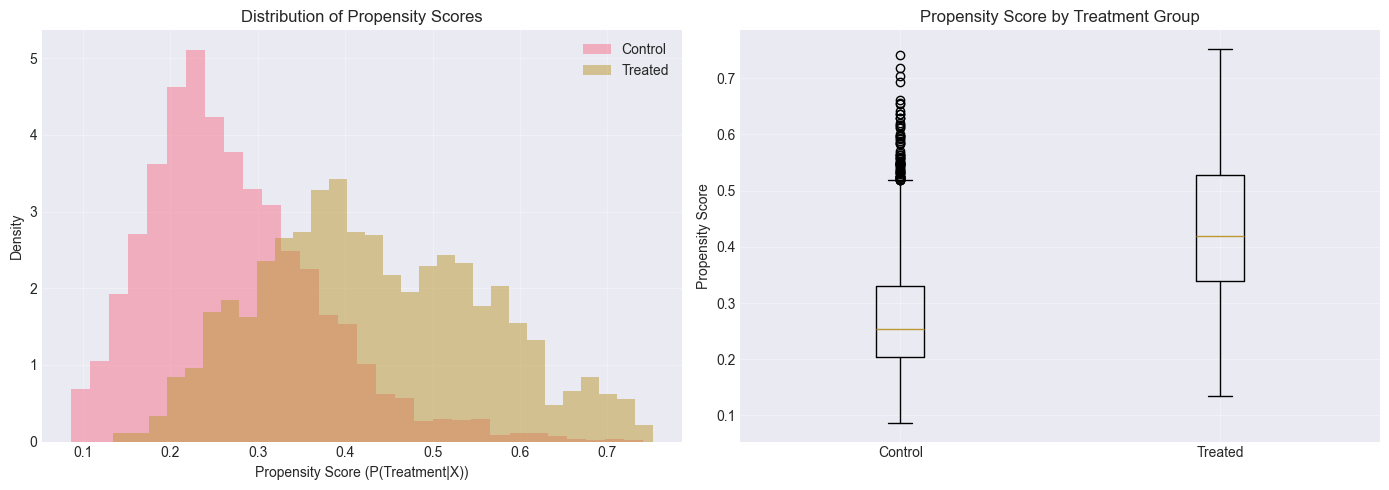

In [43]:
# Estimate propensity scores (probability of treatment given X)
from sklearn.ensemble import RandomForestClassifier

print("Checking Overlap Assumption...")
print("=" * 50)

# Fit propensity score model
ps_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
ps_model.fit(X_scaled, D)
propensity_scores = ps_model.predict_proba(X_scaled)[:, 1]

# Visualize overlap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of propensity scores
axes[0].hist(propensity_scores[D==0], bins=30, alpha=0.5, label='Control', density=True)
axes[0].hist(propensity_scores[D==1], bins=30, alpha=0.5, label='Treated', density=True)
axes[0].set_xlabel('Propensity Score (P(Treatment|X))')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Propensity Scores')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot comparison
axes[1].boxplot([propensity_scores[D==0], propensity_scores[D==1]], 
                labels=['Control', 'Treated'])
axes[1].set_ylabel('Propensity Score')
axes[1].set_title('Propensity Score by Treatment Group')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [44]:
# Check common support
common_support_region = (propensity_scores > 0.1) & (propensity_scores < 0.9)
pct_common_support = common_support_region.mean() * 100

print(f"\nOverlap Statistics:")
print(f"  Min propensity score: {propensity_scores.min():.3f}")
print(f"  Max propensity score: {propensity_scores.max():.3f}")
print(f"  % with good overlap (0.1 < P < 0.9): {pct_common_support:.1f}%")

if pct_common_support > 80:
    print("\n✓ Good overlap - comparison is valid!")
else:
    print("\n⚠ Limited overlap - results may be less reliable")


Overlap Statistics:
  Min propensity score: 0.087
  Max propensity score: 0.752
  % with good overlap (0.1 < P < 0.9): 99.8%

✓ Good overlap - comparison is valid!


## 10. Using Existing Libraries: DoubleML Package

While it's important to understand the mechanics of DML (as we've done above), in practice you can use established libraries that handle all the details for you.

The **DoubleML** package is the official Python implementation by the original DML authors.


In [45]:
# !pip install doubleml

In [47]:
import doubleml as dml
from doubleml import DoubleMLPLR

In [48]:
dml_data = dml.DoubleMLData(
        df,
        y_col='outcome',
        d_cols=['treatment'],
        x_cols=confounder_vars
    )

In [53]:
ml_l = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)  # For outcome
ml_m = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)  # For treatment

In [54]:
# Initialize the Double ML model
dml_plr = DoubleMLPLR(
        dml_data,
        ml_l=ml_l,
        ml_m=ml_m,
        n_folds=5,
        score='partialling out',  # The standard DML approach
        )

In [55]:
print("Fitting DoubleML model...")
dml_plr.fit()

Fitting DoubleML model...


In [56]:
print("\n" + "="*60)
print("DOUBLEML PACKAGE RESULTS:")
print("="*60)
print(dml_plr.summary)


DOUBLEML PACKAGE RESULTS:
               coef   std err          t         P>|t|     2.5 %   97.5 %
treatment -1.011902  0.055732 -18.156725  1.136027e-73 -1.121134 -0.90267


In [57]:
# Extract values for comparison
package_ate = dml_plr.coef[0]
package_se = dml_plr.se[0]
package_pval = dml_plr.pval[0]
package_ci = dml_plr.confint()

print("\n" + "="*60)
print("COMPARISON: Manual vs Package Implementation")
print("="*60)
print(f"                     Manual DML    DoubleML Package")
print(f"                     ----------    ----------------")
print(f"ATE Estimate:        {ate_dml:8.4f}      {package_ate:8.4f}")
print(f"Standard Error:      {se_ate:8.4f}      {package_se:8.4f}")
print(f"95% CI Lower:        {ci_lower:8.4f}      {package_ci.iloc[0,0]:8.4f}")
print(f"95% CI Upper:        {ci_upper:8.4f}      {package_ci.iloc[0,1]:8.4f}")
print(f"P-value:             {p_value:8.4f}      {package_pval:8.4f}")
print("="*60)


COMPARISON: Manual vs Package Implementation
                     Manual DML    DoubleML Package
                     ----------    ----------------
ATE Estimate:         -1.0195       -1.0119
Standard Error:        0.0553        0.0557
95% CI Lower:         -1.1279       -1.1211
95% CI Upper:         -0.9111       -0.9027
P-value:               0.0000        0.0000


### Advantages of Using the DoubleML Package

The professional implementation offers several benefits:

1. **Validated Implementation**: Tested and maintained by the original authors
2. **Additional Features**: Bootstrap CIs, multiple treatments, sensitivity analysis
3. **Convenience**: Handles all the details automatically
4. **Speed**: Optimized implementation
5. **Documentation**: Extensive guides and examples

However, understanding the manual implementation (as we did above) is crucial for:
- Knowing what's happening "under the hood"
- Debugging when things go wrong
- Customizing for special cases
- Building intuition about the method

## 11. Pros and Cons of Double Machine Learning

### Advantages of DML:

1. FLEXIBILITY WITH ML METHODS  
   - Use any ML algorithm (RF, XGBoost, Neural Networks, etc.)  
   - Automatically handles non-linearities and interactions  
   - No need to specify functional forms
     

2. VALID STATISTICAL INFERENCE  
   - Provides correct standard errors and p-values  
   - Enables hypothesis testing despite using ML  
   - Confidence intervals have proper coverage  


3. HANDLES HIGH-DIMENSIONAL DATA  
   - Works with many confounders (p >> n scenarios)  
   - Automatic feature selection via regularization  
   - Reduces overfitting through cross-fitting  


4. ROBUST TO MODEL MISSPECIFICATION  
   - Less sensitive to wrong functional form assumptions  
   - Double robustness property in some cases  
   - Consistent under weaker conditions than OLS  


5. REDUCES REGULARIZATION BIAS  
   - Orthogonalization removes bias from ML regularization  
   - Neyman orthogonality ensures sqrt(n)-consistency  
   - Cross-fitting prevents overfitting bias  

---

### Limitations and Considerations:

1. SAMPLE SIZE REQUIREMENTS  
   - Needs relatively large samples (ideally n > 1000)  
   - Cross-fitting reduces effective sample size  
   - May be unstable with small samples  


2. COMPUTATIONAL COST  
   - More computationally intensive than OLS  
   - Requires fitting multiple ML models  
   - Cross-fitting multiplies computation time  


3. STILL REQUIRES KEY ASSUMPTIONS  
   - Unconfoundedness: All confounders must be measured  
   - Overlap: Treatment and control groups must be comparable  
   - SUTVA: No interference between units  
   - Cannot handle unobserved confounding  


4. MODEL SELECTION CHALLENGES  
   - Results can vary with ML method choice  
   - Hyperparameter tuning adds complexity  
   - No universal best ML approach  


5. INTERPRETABILITY  
   - Black-box ML models reduce interpretability  
   - Cannot easily see which variables matter most  
   - Harder to diagnose problems than with linear models  


6. LIMITED TO SPECIFIC PARAMETERS  
   - Primarily designed for average effects  
   - Extensions needed for other causal parameters  
   - Not all causal questions fit the DML framework


## 13. Resources for Further Learning

### Python Libraries for Causal ML

1. **DoubleML (Official DML Implementation)**
   - Install: `pip install doubleml`
   - Docs: https://docs.doubleml.org
   - Features: DML, GATE, ATE, sensitivity analysis

2. **EconML (Microsoft)**
   - Install: `pip install econml`
   - Docs: https://econml.azurewebsites.net/
   - Features: DML, Causal Forests, Meta-learners, IV methods

3. **CausalML (Uber)**
   - Install: `pip install causalml`
   - Docs: https://causalml.readthedocs.io/
   - Features: Uplift modeling, Meta-learners, Tree-based methods

4. **DoWhy (Microsoft/PyWhy)**
   - Install: `pip install dowhy`
   - Docs: https://py-why.github.io/dowhy/
   - Features: Causal graphs, identification, refutation tests

5. **CausalPy**
   - Install: `pip install causalpy`
   - Docs: https://github.com/pymc-labs/CausalPy
   - Features: Bayesian causal inference, synthetic controls

---

### Essential Readings for Double Machine Learning

#### Foundational Papers
1. Chernozhukov et al. (2018) — “Double/debiased machine learning for treatment and structural parameters”  
   - The original DML paper, essential reading  
   - https://arxiv.org/abs/1608.00060

2. Athey & Imbens (2019) — “Machine Learning Methods That Economists Should Know About”  
   - Excellent overview of ML in causal inference  
   - https://arxiv.org/abs/1903.10075

3. Belloni et al. (2014) — “Inference on Treatment Effects after Selection among High-Dimensional Controls”  
   - Foundation for using LASSO in causal inference  
   - https://arxiv.org/abs/1201.0224

#### Practical Guides
4. “User Guide for DoubleML”  
   - Step-by-step implementation guide  
   - https://docs.doubleml.org/stable/guide/guide.html

5. “Introduction to Double Machine Learning” (DoubleML Tutorial)  
   - Hands-on Python tutorial  
   - https://docs.doubleml.org/stable/intro/intro.html

#### Advanced Topics
6. Chernozhukov et al. (2022) — “Generic Machine Learning Inference on Heterogeneous Treatment Effects”  
   - Extension to heterogeneous effects  
   - https://arxiv.org/abs/1712.04802

7. Syrgkanis et al. (2019) — “Machine Learning Estimation of Heterogeneous Treatment Effects”  
   - EconML paper with practical algorithms  
   - https://arxiv.org/abs/1903.00140

#### Online Courses
8. “Machine Learning and Causal Inference” — Susan Athey (Stanford)  
   - Comprehensive course on ML + Causality

9. “Modern Topics in Causal Inference” — Various lectures on YouTube  
   - Search for talks by Chernozhukov, Athey, Imbens

#### Textbooks
10. “Causal Inference: The Mixtape” by Scott Cunningham  
    - Free online book with DML chapter  
    - https://mixtape.scunning.com/

11. “The Effect” by Nick Huntington-Klein  
    - Modern causal inference with code examples  
    - https://theeffectbook.net/


## 14. Further Exploration: Heterogeneous Effects (Advanced)

For those interested in diving deeper, here's how to explore heterogeneous treatment effects:
1. BY PRE-TEST SCORES:
   - Split sample by median pre-test score
   - Run DML separately for high/low performers
   - Compare if treatment helps one group more

2. BY DEMOGRAPHICS:
   - Analyze effects by gender, race, or income
   - Check if program has equitable impacts
   - Important for policy recommendations

3. BY GEOGRAPHY:
   - Urban vs rural effects
   - Distance to college effects
   - Regional variation in program impact
